In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from skimpy import clean_columns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load Data

In [3]:
DATA_DIR = 'data'
def data_path(filename, data_dir = DATA_DIR):
    return f"{data_dir}/{filename}"
air_pollution_filename = "air_pollution_emissions.csv"
alcohol_expenditure_filename = "alcohol_expenditure_usa_long_term.csv"
cancer_death_filename = "cancer_death_rates_in_the_US_over_the_long_term.csv"
hospital_admissions_filename = "total-hospital-admissions-in-the-united-states-1946-2019.xlsx"
demographic_indicators_filename = "WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx"

### Hospital Admissions

In [4]:
# read data
hospital_admissions = pd.read_excel(data_path(hospital_admissions_filename), sheet_name = 1)
# remove junk columns & rows
hospital_admissions = hospital_admissions.drop(columns=['Unnamed: 0'])
hospital_admissions = hospital_admissions.iloc[4:,:]
# rename columns
hospital_admissions.rename(columns={'Unnamed: 1':'year', 'Unnamed: 2':'num_admissions_1000s'}, inplace=True)
# fix type
hospital_admissions['year'] = pd.to_numeric(hospital_admissions['year'])
# set dates
hospital_admissions = hospital_admissions.loc[(hospital_admissions['year'] >= 1950) & (hospital_admissions['year'] <= 2011)]
hospital_admissions.set_index('year', inplace=True)

In [5]:
hospital_admissions.head(10)

,num_admissions_1000s
year,
1950,18483.0
1955,21073.0
1960,25027.0
1965,28812.0
1970,31759.0
1971,32664.0
1972,33265.0
1973,34352.0
1974,35506.0


<AxesSubplot: xlabel='year'>

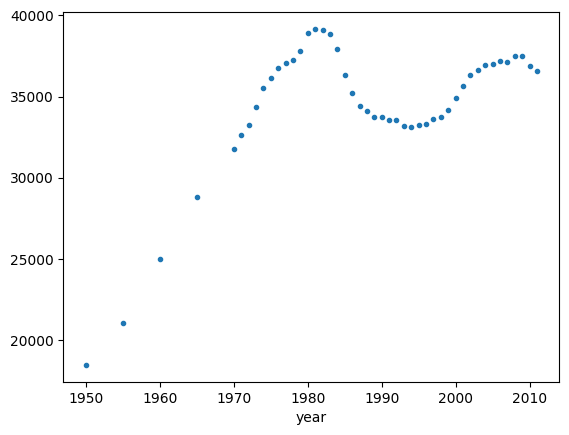

In [6]:
hospital_admissions['num_admissions_1000s'].plot(style='.')

### Demographic Indicators

In [7]:
# read data
demographic_indicators = pd.read_excel(data_path(demographic_indicators_filename), sheet_name=0)
# remove junk rows and set header
demographic_indicators_header = demographic_indicators.iloc[15,:]
demographic_indicators = demographic_indicators.iloc[16:,:]
demographic_indicators.columns = demographic_indicators_header
# select USA data
demographic_indicators = demographic_indicators.loc[demographic_indicators['Region, subregion, country or area *'] == 'United States of America']
# rename columns
demographic_indicators.rename(
    columns={'Year': 'year',
             'Total Population, as of 1 July (thousands)': 'total_population',
             'Male Population, as of 1 July (thousands)': 'male_population',
             'Female Population, as of 1 July (thousands)': 'female_population'},
    inplace=True)
# select relevant columns
demographic_cols = ['year', 'total_population', 'male_population', 'female_population']
demographic_indicators = demographic_indicators[demographic_cols]
# set dates and index
demographic_indicators = demographic_indicators.loc[(demographic_indicators['year'] >= 1950) & (demographic_indicators['year'] <= 2011)]
demographic_indicators.columns.name = None
demographic_indicators.set_index('year', inplace=True)
demographic_indicators

,total_population,male_population,female_population
year,,,
1950,148281.55,73516.095,74765.455
1951,150598.453,74784.499,75813.955
1952,152941.727,76079.283,76862.444
1953,155451.199,77221.443,78229.756
1954,158205.873,78577.893,79627.98
...,...,...,...
2007,302743.399,149147.06,153596.338
2008,305694.91,150592.791,155102.12
2009,308512.035,151968.684,156543.351


### Cancer Death Rates (per 100,000)

In [8]:
# read data
cancer_death = pd.read_csv(data_path(cancer_death_filename))
# set dates
cancer_death = cancer_death.loc[(cancer_death['Year'] >= 1950) & (cancer_death['Year'] <= 2011)]
# basic cleaning
cancer_death = clean_columns(cancer_death)
cancer_death.drop('entity', axis=1, inplace=True)
cancer_death.set_index('year', inplace=True)
cancer_death.head()

16 column names have been cleaned

,stomach_male,colon_and_rectum_male,liver_male,pancreas_male,lung_and_bronchus_male,prostate_male,leukemia_male,stomach_female,colon_and_rectum_female,pancreas_female,lung_and_bronchus_female,breast_female,uterus_female,liver_female
year,,,,,,,,,,,,,,
1950,31.1,33.1,8.6,9.9,24.3,28.9,8.2,17.6,32.3,6.8,5.8,31.9,26.2,9.8
1951,29.7,32.3,8.3,10.3,25.8,28.6,8.7,16.5,31.9,6.7,5.9,31.6,24.5,9.4
1952,28.7,32.8,8.1,10.4,28.0,29.7,8.8,16.1,31.5,7.1,6.1,31.6,23.8,9.5
1953,28.1,33.0,8.0,10.7,30.4,29.8,9.1,15.6,31.4,7.1,6.0,32.2,23.6,9.2
1954,27.3,32.6,7.7,11.2,31.7,30.5,9.4,14.8,31.2,7.3,6.0,31.8,22.5,8.7


### Alcohol Expenditure

In [9]:
alcohol_expenditure = pd.read_csv(data_path(alcohol_expenditure_filename))
# select dates
alcohol_expenditure = alcohol_expenditure.loc[(alcohol_expenditure['Year'] >= 1950) & (alcohol_expenditure['Year'] <= 2011)]
# clean names and set index
alcohol_expenditure = clean_columns(alcohol_expenditure)
alcohol_expenditure.set_index('year', inplace=True)
# rename and subset relevant cols
alcohol_expenditure.rename(
    columns={'total_at_home_usda_2018': 'alc_exp_at_home',
             'total_away_from_home': 'alc_exp_away_fr_home',
             'total_alcohol_expenditure_usda_2018': 'alc_exp_total'},
    inplace=True
)
relevant_alc_cols = [
    'alc_exp_at_home',
    'alc_exp_away_fr_home',
    'alc_exp_total'
]
alcohol_expenditure = alcohol_expenditure[relevant_alc_cols]
alcohol_expenditure.head()

11 column names have been cleaned

,alc_exp_at_home,alc_exp_away_fr_home,alc_exp_total
year,,,
1950,3455000000,4413000000,7868000000
1951,3789000000,4765000000,8554000000
1952,3999000000,4899000000,8898000000
1953,4080000000,4960000000,9040000000
1954,4189000000,4946000000,9135000000


### Air Pollution

In [10]:
# read data
air_pollution = pd.read_csv(data_path(air_pollution_filename), low_memory=False)
# select USA data
air_pollution = air_pollution.loc[air_pollution['Entity'] == 'United States']
# fix column dtype
air_pollution['nh3_per_capita'] = pd.to_numeric(air_pollution['nh3_per_capita'])
# select dates 
air_pollution = air_pollution.loc[(air_pollution['Year'] >= 1950) & (air_pollution['Year'] <= 2011)]
# clean names and set index
air_pollution = clean_columns(air_pollution)
air_pollution.set_index('year', inplace=True)
# subset cols
air_pol_rel_cols = [
    'nox_per_capita', 
    'so_2_per_capita', 
    'co_per_capita', 
    'oc_per_capita',
    'nmvoc_per_capita', 
    'bc_per_capita', 
    'nh_3_per_capita'
]
air_pollution = air_pollution[air_pol_rel_cols]
air_pollution.head()

6 column names have been cleaned

,nox_per_capita,so_2_per_capita,co_per_capita,oc_per_capita,nmvoc_per_capita,bc_per_capita,nh_3_per_capita
year,,,,,,,
1950,87.872567,113.791573,660.499190,6.120093,106.463437,3.749932,9.289717
1951,92.284438,117.679654,681.203964,5.698752,111.268008,3.501867,9.570112
1952,92.125837,111.202933,680.903893,5.305718,112.090448,3.221975,9.744620
1953,93.192457,111.909954,690.662295,4.836261,114.208577,2.935008,9.946302
1954,90.616479,102.869296,674.088049,4.476236,112.303428,2.655331,10.007221


# Data Wrangling

#### Hospital admissions

Between 1950 and 1970, the data is recorded every 5 years. We will have to introduce the missing years into the data and fill in the missing values (using pandas' interpolation).

In [11]:
hospital_admissions = hospital_admissions.reindex(range(1950, 2012))
hospital_admissions.head(7)

,num_admissions_1000s
year,
1950,18483.0
1951,NaN
1952,NaN
1953,NaN
1954,NaN
1955,21073.0
1956,NaN


We try 3 methods of interpolation – linear, quadratic and cubic, and plot their values.

<AxesSubplot: xlabel='year'>

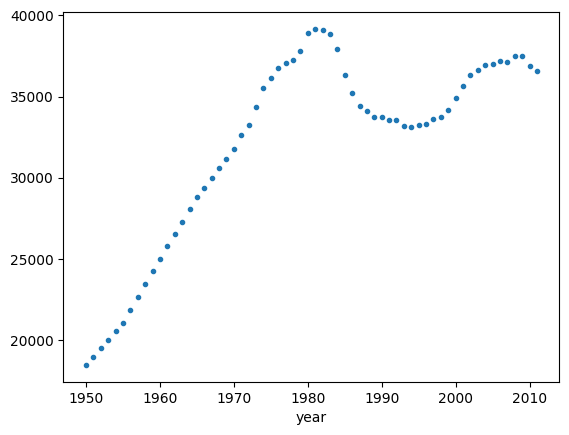

In [12]:
hospital_admissions.interpolate(method='linear')['num_admissions_1000s'].plot(style='.')

<AxesSubplot: xlabel='year'>

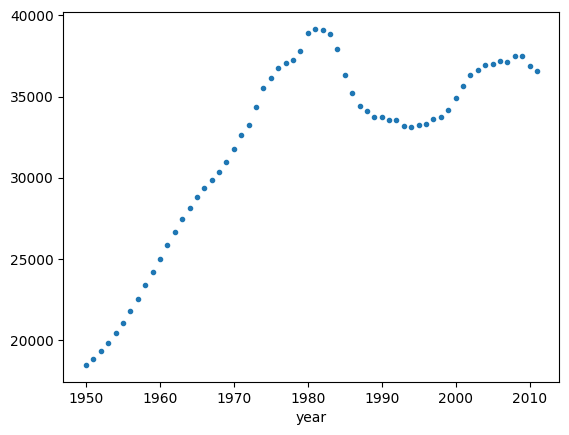

In [13]:
hospital_admissions.interpolate(method='quadratic')['num_admissions_1000s'].plot(style='.')

<AxesSubplot: xlabel='year'>

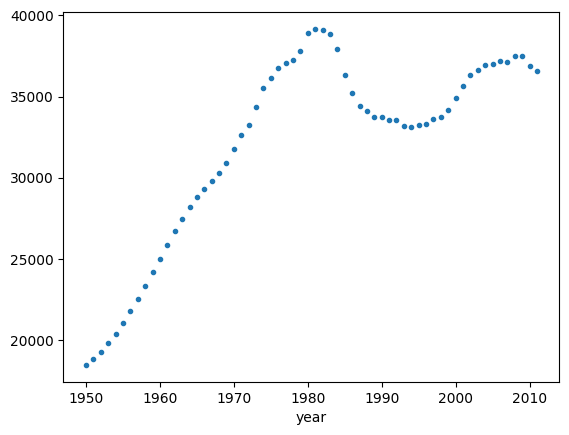

In [14]:
hospital_admissions.interpolate(method='cubic')['num_admissions_1000s'].plot(style='.')

We see that the quadratic interpolation appears to give more realistic looking values when simply comparin their plots. When using cubic interpolation, we see that there does not appear to be any significant difference compared to the quadratic interpolation, and thus we settle on the quadratic interpolation, so as to avoid potential overfitting with a higher order polynomial interoplation.

In [15]:
hospital_admissions.interpolate(method='quadratic', inplace=True)

We are interested in the admissions per capita, and as such, in our pre-processing step we will multiply the `num_admissions_1000s` column by $1000$ in order to achieve the approximate raw number of approximations, which we will later divide by the population.

In [16]:
hospital_admissions['num_admissions_total'] = hospital_admissions['num_admissions_1000s'] * 1000
hospital_admissions.head()

,num_admissions_1000s,num_admissions_total
year,,
1950,18483.000000,1.848300e+07
1951,18874.298477,1.887430e+07
1952,19328.947715,1.932895e+07
1953,19846.947715,1.984695e+07
1954,20428.298477,2.042830e+07


#### Joining and Further Processing

In [17]:
merged_df = hospital_admissions.copy()
dfs_to_merge = [
    demographic_indicators,
    cancer_death,
    alcohol_expenditure,
    air_pollution
]

In [18]:
for df in dfs_to_merge:
    merged_df = merged_df.merge(
        df, 
        how='left',
        left_index=True,
        right_index=True,
        suffixes=(None, None)
    )
merged_df.head()

,num_admissions_1000s,num_admissions_total,total_population,male_population,female_population,stomach_male,colon_and_rectum_male,liver_male,pancreas_male,lung_and_bronchus_male,...,alc_exp_at_home,alc_exp_away_fr_home,alc_exp_total,nox_per_capita,so_2_per_capita,co_per_capita,oc_per_capita,nmvoc_per_capita,bc_per_capita,nh_3_per_capita
year,,,,,,,,,,,,,,,,,,,,,
1950,18483.000000,1.848300e+07,148281.55,73516.095,74765.455,31.1,33.1,8.6,9.9,24.3,...,3455000000,4413000000,7868000000,87.872567,113.791573,660.499190,6.120093,106.463437,3.749932,9.289717
1951,18874.298477,1.887430e+07,150598.453,74784.499,75813.955,29.7,32.3,8.3,10.3,25.8,...,3789000000,4765000000,8554000000,92.284438,117.679654,681.203964,5.698752,111.268008,3.501867,9.570112
1952,19328.947715,1.932895e+07,152941.727,76079.283,76862.444,28.7,32.8,8.1,10.4,28.0,...,3999000000,4899000000,8898000000,92.125837,111.202933,680.903893,5.305718,112.090448,3.221975,9.744620
1953,19846.947715,1.984695e+07,155451.199,77221.443,78229.756,28.1,33.0,8.0,10.7,30.4,...,4080000000,4960000000,9040000000,93.192457,111.909954,690.662295,4.836261,114.208577,2.935008,9.946302
1954,20428.298477,2.042830e+07,158205.873,78577.893,79627.98,27.3,32.6,7.7,11.2,31.7,...,4189000000,4946000000,9135000000,90.616479,102.869296,674.088049,4.476236,112.303428,2.655331,10.007221


In [19]:
merged_df.columns

Index(['num_admissions_1000s', 'num_admissions_total', 'total_population',
       'male_population', 'female_population', 'stomach_male',
       'colon_and_rectum_male', 'liver_male', 'pancreas_male',
       'lung_and_bronchus_male', 'prostate_male', 'leukemia_male',
       'stomach_female', 'colon_and_rectum_female', 'pancreas_female',
       'lung_and_bronchus_female', 'breast_female', 'uterus_female',
       'liver_female', 'alc_exp_at_home', 'alc_exp_away_fr_home',
       'alc_exp_total', 'nox_per_capita', 'so_2_per_capita', 'co_per_capita',
       'oc_per_capita', 'nmvoc_per_capita', 'bc_per_capita',
       'nh_3_per_capita'],
      dtype='object')

In [20]:
df = merged_df.copy()

We have all the data joined and will perform the following processing:
1. Get the hospital admissions per capita
2. Get the complete death rate for each cancer type (remove separation by gender)
3. Get the complete death rate from all types of cancer
4. Get the alcohol expenditure values per capita

In [21]:
# get hospital admissions per capita
df['admissions_per_capita'] = df['num_admissions_total'] / df['total_population']

In [22]:
def cancer_deaths_helper(df, cancer_type):
    n_indiv = 100_000
    male_col = f"{cancer_type}_male"
    female_col = f"{cancer_type}_female"
    try:
        male_deaths = (df[male_col] / n_indiv) * df['male_population']
    except Exception as e:
        male_deaths = 0
    try:
        female_deaths = (df[female_col] / n_indiv) * df['female_population']
    except Exception as e:
        female_deaths = 0
    deaths = male_deaths + female_deaths
    total_rate = deaths / df['total_population']
    return total_rate

In [23]:
# get death rate per cancer type
cancer_types = ['stomach', 'colon_and_rectum', 'liver', 'pancreas', 'lung_and_bronchus',
                'prostate', 'leukemia', 'breast', 'uterus']

for cancer_type in cancer_types:
    df[cancer_type] = cancer_deaths_helper(df, cancer_type)


In [24]:
# get cancer death rates total
df['all_cancer'] = 0
for cancer_type in cancer_types:
    df['all_cancer'] += df[cancer_type]

In [25]:
# get alcohol expenditure per capita
df['alc_exp_at_home_per_capita'] = df['alc_exp_at_home'] / df['total_population']
df['alc_exp_away_fr_home_per_capita'] = df['alc_exp_away_fr_home'] / df['total_population']
df['alc_exp_total_per_capita'] = df['alc_exp_total'] / df['total_population']

In [26]:
columns_of_interest = [
    'stomach_male', 'colon_and_rectum_male', 'liver_male', 'pancreas_male',
    'lung_and_bronchus_male', 'prostate_male', 'leukemia_male',
    'stomach_female', 'colon_and_rectum_female', 'pancreas_female',
    'lung_and_bronchus_female', 'breast_female', 'uterus_female',
    'liver_female', 'nox_per_capita', 'so_2_per_capita', 'co_per_capita',
    'oc_per_capita', 'nmvoc_per_capita', 'bc_per_capita', 'nh_3_per_capita',
    'admissions_per_capita', 'stomach', 'colon_and_rectum', 'liver',
    'pancreas', 'lung_and_bronchus', 'prostate', 'leukemia', 'breast', 'uterus',
    'all_cancer', 'alc_exp_at_home_per_capita',
    'alc_exp_away_fr_home_per_capita', 'alc_exp_total_per_capita'
]
df_clean = df[columns_of_interest]

# EDA

In [28]:
def multiplePlots(series):

    fig, axs = plt.subplots(2, 2)
    plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)

    # Histogram
    sns.histplot(series, ax=axs[0, 0])

    # Lag plot
    lag = series.copy()
    lag = np.array(lag[:-1])
    current = series[1:]
    ax = sns.regplot(x=current, y=lag, fit_reg=False, ax=axs[0, 1])
    ax.set_ylabel("y_i-1")
    ax.set_xlabel("y_i")

    # QQ plot
    qntls, xr = stats.probplot(series, fit=False)
    sns.regplot(x=xr, y=qntls, ax=axs[1, 0])

    # Run sequence
    ax = sns.regplot(x=np.arange(len(series)), y=series, ax=axs[1, 1])
    ax.set_ylabel("val")
    ax.set_xlabel("i")

In [29]:
df_clean.columns

Index(['stomach_male', 'colon_and_rectum_male', 'liver_male', 'pancreas_male',
       'lung_and_bronchus_male', 'prostate_male', 'leukemia_male',
       'stomach_female', 'colon_and_rectum_female', 'pancreas_female',
       'lung_and_bronchus_female', 'breast_female', 'uterus_female',
       'liver_female', 'nox_per_capita', 'so_2_per_capita', 'co_per_capita',
       'oc_per_capita', 'nmvoc_per_capita', 'bc_per_capita', 'nh_3_per_capita',
       'admissions_per_capita', 'stomach', 'colon_and_rectum', 'liver',
       'pancreas', 'lung_and_bronchus', 'prostate', 'leukemia', 'breast',
       'uterus', 'all_cancer', 'alc_exp_at_home_per_capita',
       'alc_exp_away_fr_home_per_capita', 'alc_exp_total_per_capita'],
      dtype='object')

In [30]:
total_cancer = df_clean.drop(columns=['stomach_male', 'colon_and_rectum_male', 'liver_male', 'pancreas_male',
       'lung_and_bronchus_male', 'prostate_male', 'leukemia_male',
       'stomach_female', 'colon_and_rectum_female', 'pancreas_female',
       'lung_and_bronchus_female', 'breast_female', 'uterus_female',
       'liver_female', 'nox_per_capita', 'so_2_per_capita', 'co_per_capita',
       'oc_per_capita', 'nmvoc_per_capita', 'bc_per_capita', 'nh_3_per_capita',
       'admissions_per_capita', 'alc_exp_at_home_per_capita',
       'alc_exp_away_fr_home_per_capita', 'alc_exp_total_per_capita'])
total_cancer = total_cancer.astype(float)
total_cancer

,stomach,colon_and_rectum,liver,pancreas,lung_and_bronchus,prostate,leukemia,breast,uterus,all_cancer
year,,,,,,,,,,
1950,0.000243,0.000327,0.000092,0.000083,0.000150,0.000143,0.000041,0.000161,0.000132,0.001372
1951,0.000231,0.000321,0.000089,0.000085,0.000158,0.000142,0.000043,0.000159,0.000123,0.001350
1952,0.000224,0.000321,0.000088,0.000087,0.000170,0.000148,0.000044,0.000159,0.000120,0.001360
1953,0.000218,0.000322,0.000086,0.000089,0.000181,0.000148,0.000045,0.000162,0.000119,0.001370
1954,0.000210,0.000319,0.000082,0.000092,0.000188,0.000151,0.000047,0.000160,0.000113,0.001363
...,...,...,...,...,...,...,...,...,...,...
2007,0.000038,0.000176,0.000066,0.000110,0.000526,0.000119,0.000047,0.000117,0.000033,0.001233
2008,0.000037,0.000172,0.000068,0.000111,0.000514,0.000113,0.000047,0.000115,0.000033,0.001209
2009,0.000035,0.000165,0.000070,0.000109,0.000500,0.000109,0.000047,0.000113,0.000033,0.001181


/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


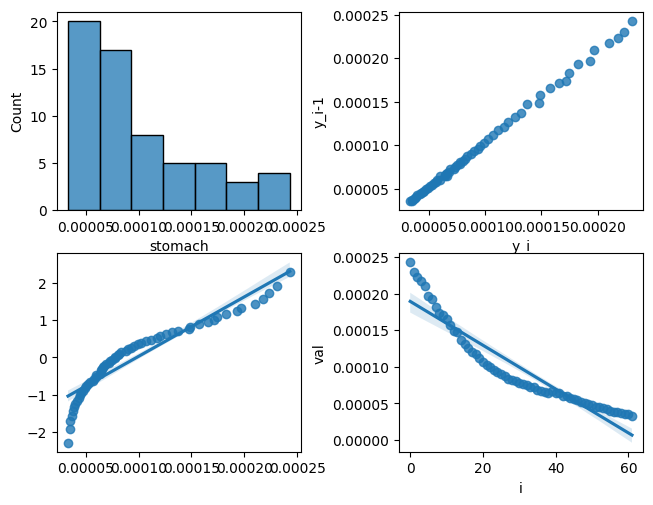

In [46]:
# total stomach cancer
multiplePlots(total_cancer['stomach'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


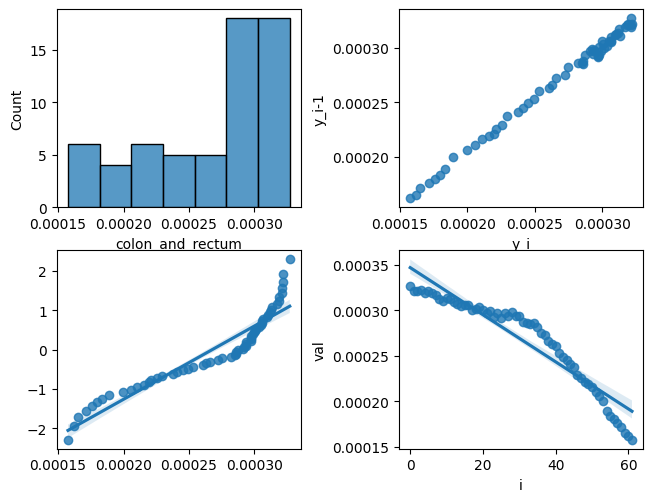

In [48]:
# total colon and rectum cancer
multiplePlots(total_cancer['colon_and_rectum'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


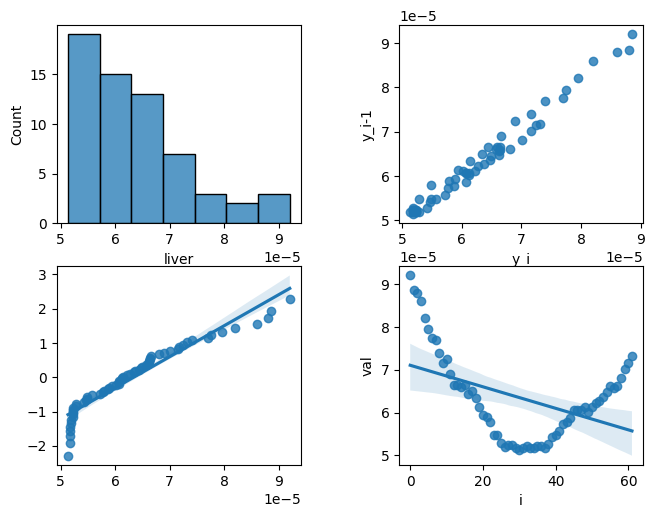

In [33]:
# total liver cancer
multiplePlots(total_cancer['liver'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


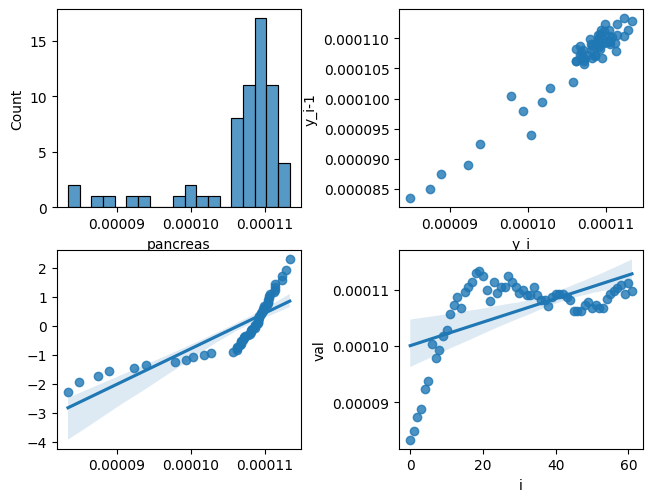

In [34]:
# total pancreas cancer
multiplePlots(total_cancer['pancreas'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


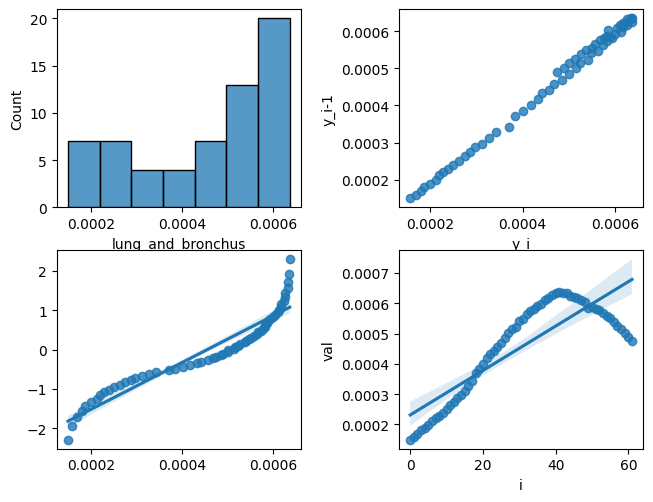

In [35]:
# total lung and bronchus cancer
multiplePlots(total_cancer['lung_and_bronchus'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


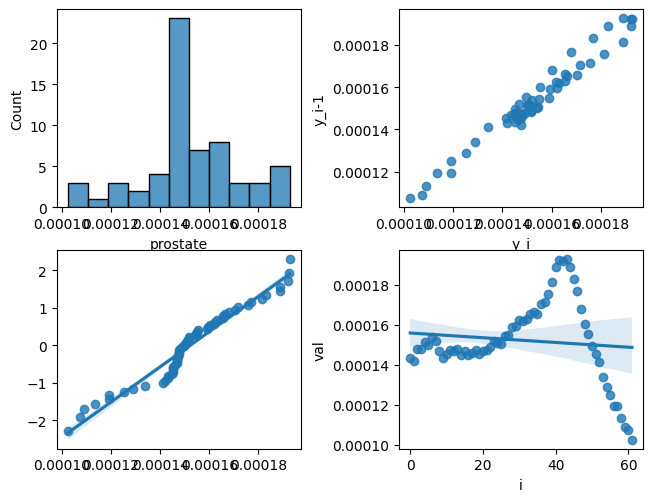

In [36]:
# total prostate cancer
multiplePlots(total_cancer['prostate'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


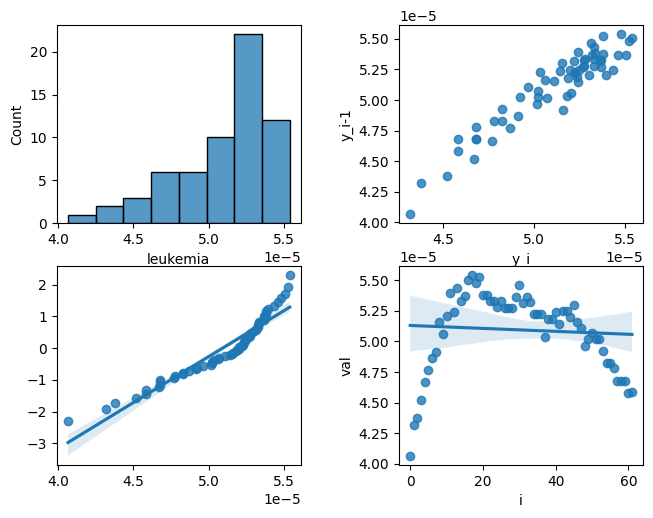

In [37]:
# total leukemia cancer
multiplePlots(total_cancer['leukemia'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


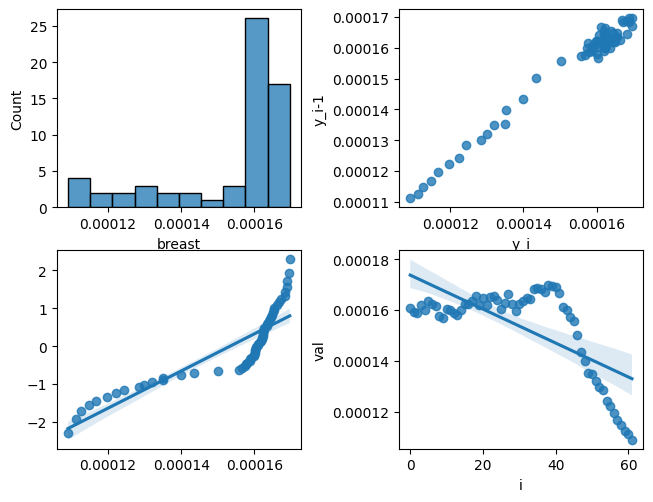

In [38]:
# total breast cancer
multiplePlots(total_cancer['breast'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


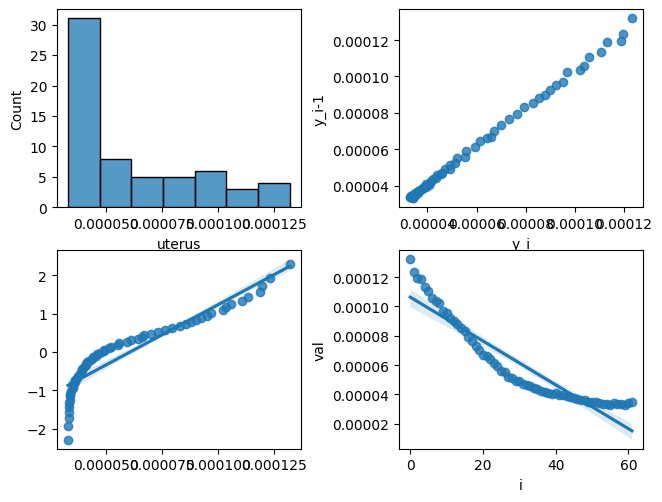

In [39]:
# total uterus cancer
multiplePlots(total_cancer['uterus'])

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lag = np.array(lag[:-1])
/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/2339689607.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  current = series[1:]


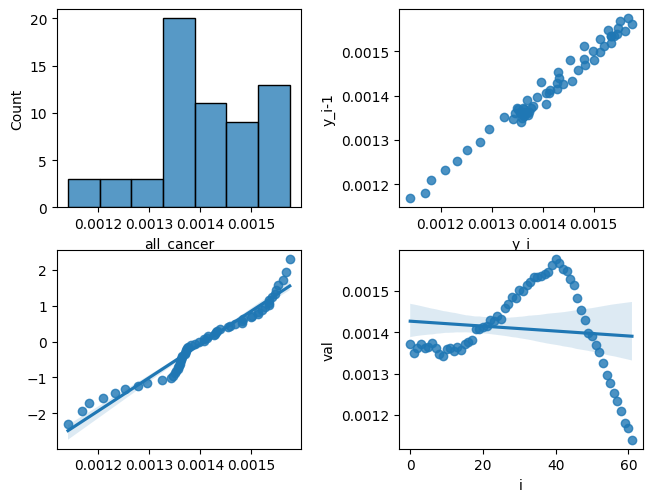

In [40]:
# total cancer
multiplePlots(total_cancer['all_cancer'])

<AxesSubplot: xlabel='year'>

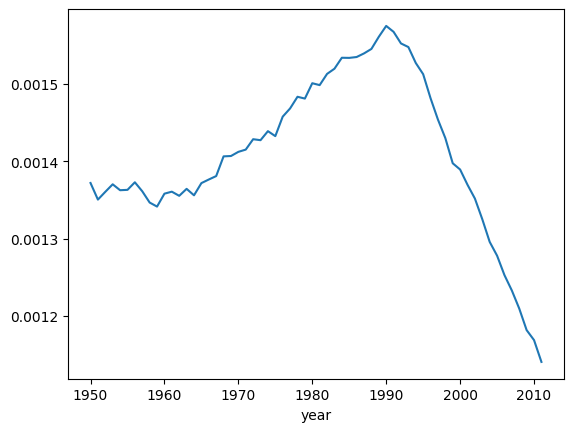

In [49]:
total_cancer['all_cancer'].plot()

<AxesSubplot: xlabel='year'>

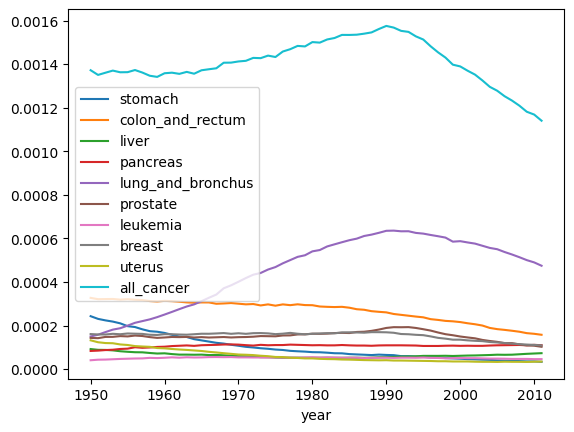

In [51]:
total_cancer.plot(y=['stomach', 'colon_and_rectum', 'liver', 'pancreas', 'lung_and_bronchus',
       'prostate', 'leukemia', 'breast', 'uterus', 'all_cancer'])

In [52]:
df_clean.corr()

/var/folders/mb/v5y51xp502v_ms8mg83v9ysh0000gn/T/ipykernel_30631/1863484124.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_clean.corr()


,stomach_male,colon_and_rectum_male,liver_male,pancreas_male,lung_and_bronchus_male,prostate_male,leukemia_male,stomach_female,colon_and_rectum_female,pancreas_female,...,breast_female,uterus_female,liver_female,nox_per_capita,so_2_per_capita,co_per_capita,oc_per_capita,nmvoc_per_capita,bc_per_capita,nh_3_per_capita
stomach_male,1.000000,0.617239,-0.152724,-0.340628,-0.826766,-0.052305,-0.268410,0.996975,0.916017,-0.976867,...,0.539484,0.993924,0.958741,0.418585,0.678190,0.661659,0.877438,0.636984,0.943223,-0.644883
colon_and_rectum_male,0.617239,1.000000,-0.854703,0.238355,-0.099773,0.520731,0.466495,0.563502,0.869307,-0.610163,...,0.960992,0.557232,0.376719,0.923061,0.925560,0.946336,0.738290,0.921229,0.704383,0.016091
liver_male,-0.152724,-0.854703,1.000000,-0.575354,-0.359203,-0.613303,-0.777989,-0.085036,-0.525329,0.157909,...,-0.832501,-0.087081,0.126225,-0.893017,-0.747184,-0.784924,-0.340602,-0.773108,-0.270676,-0.438066
pancreas_male,-0.340628,0.238355,-0.575354,1.000000,0.444605,0.055214,0.847717,-0.392766,-0.022109,0.350063,...,0.176913,-0.330425,-0.492693,0.470216,0.327093,0.350422,-0.364358,0.405659,-0.322889,0.797667
lung_and_bronchus_male,-0.826766,-0.099773,-0.359203,0.444605,1.000000,0.535641,0.570381,-0.856160,-0.575939,0.802161,...,0.011240,-0.874478,-0.934844,0.070632,-0.265076,-0.236209,-0.543852,-0.236307,-0.673965,0.741921
prostate_male,-0.052305,0.520731,-0.613303,0.055214,0.535641,1.000000,0.483313,-0.095096,0.166059,0.078701,...,0.688096,-0.142163,-0.235433,0.475955,0.280899,0.280280,0.196228,0.235679,0.057602,0.160711
leukemia_male,-0.268410,0.466495,-0.777989,0.847717,0.570381,0.483313,1.000000,-0.331583,0.105542,0.283570,...,0.469225,-0.295918,-0.478347,0.612985,0.413129,0.440969,-0.214327,0.467428,-0.243667,0.701167
stomach_female,0.996975,0.563502,-0.085036,-0.392766,-0.856160,-0.095096,-0.331583,1.000000,0.886242,-0.975141,...,0.484065,0.995021,0.975149,0.358975,0.629237,0.610303,0.866774,0.585102,0.936312,-0.681615
colon_and_rectum_female,0.916017,0.869307,-0.525329,-0.022109,-0.575939,0.166059,0.105542,0.886242,1.000000,-0.900502,...,0.784189,0.890197,0.771312,0.729188,0.895840,0.896425,0.870099,0.875683,0.911370,-0.347607
pancreas_female,-0.976867,-0.610163,0.157909,0.350063,0.802161,0.078701,0.283570,-0.975141,-0.900502,1.000000,...,-0.518148,-0.970484,-0.935386,-0.447228,-0.689343,-0.668996,-0.868356,-0.643996,-0.950931,0.585399


<AxesSubplot: >

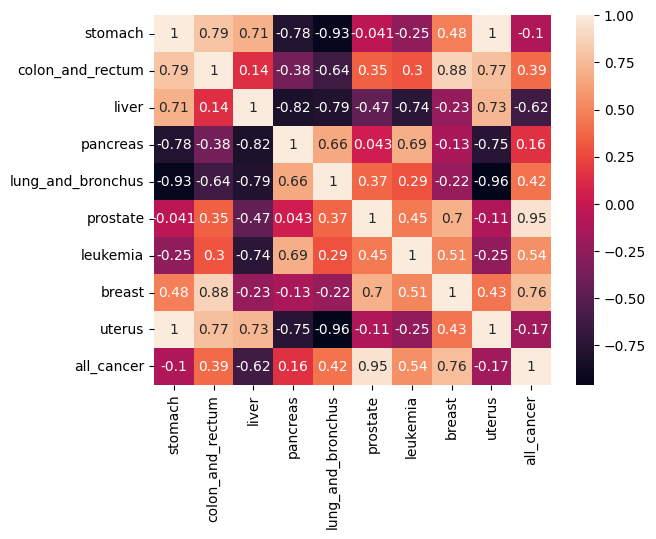

In [55]:
sns.heatmap(total_cancer.corr(), annot=True)

<AxesSubplot: xlabel='year'>

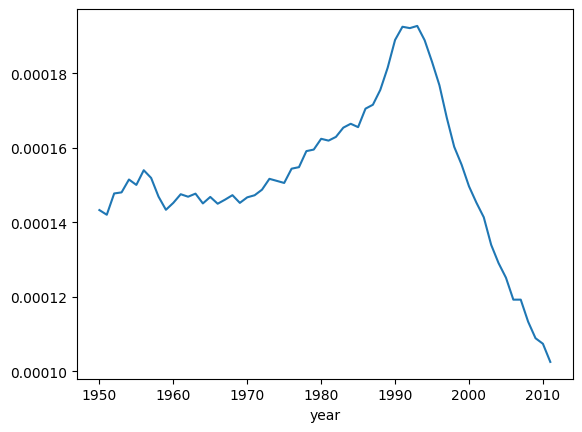

In [56]:
total_cancer['prostate'].plot()

<AxesSubplot: xlabel='year'>

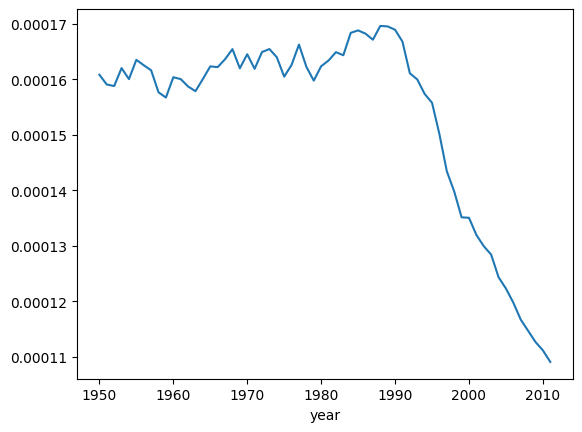

In [57]:
total_cancer['breast'].plot()

`N.B. I'm leavin the male and female cancer stuff there in case we want to do some EDA split by gender`

Most columns are not normally distributed and have either slight or heavy skews. For example, total stomach cancer has a right skew but total prostate cancer is heavily centered. However, the lag plot verifies that each column is consistent with time.

When plotting the yearly differences of the each cancer types, we can see that some cancers have spikes that are directly correlated to yearly data. Total cancer had a major spike between 1980 and 1990, and then linearly plummeted from 1990-2010. Total Lung cancer rates showed similar trends. While visualizing, we also verified that some cancers uterus, pancreas, liver, leukemia, etc. stayed constant throughout the years in the dataset. However, other cancers like colon and rectum, and stomach had drops compared to breast cancer that had a small increase between 1980-1990. Prostate cancer also had a small spike around 1990 and fell around 1995.

We wanted to test the correlation between different and total cancer to see if these trends line up with our findings. On the heatmap, we were surprised to see that breast and prostate cancer had higher correlations than lung and bronchus.

However, since lung and bronchus has a 0.42 correlation, we may infer that there is a small correlation to total cancer data. Prostate cancer having 0.95 correlation infers that there is a heavy correlation between the total and pancreatic cancer. Similar could be said about breast cancer with 0.76 correlation. Compared to lung cancer, prostate cancer has a similar graph to total cancer. Although lung cancer has a higher weight, but the graph moves a bit differently and we can see a slightly sharper drop on total cancer than lung cancer.

Another surprising thing we see is the '1' correlation between uterus and stomach cancer. Liver cancer had a decent correlation of 0.71 to stomach cancer while colon and rectum cancer had 0.79. The original line graph shows really similar slopes between uterus and stomach cancer.

Smaller findings are negative correlations in lung-uterus, lung-stomach, liver-pancreas, etc.

Since the weight of lung cancer is higher than others, its' contribution to total cancer is higher. The correlation is .42 (not low but not particularly high). However, when looking at the line plot, the other cancers have a very different distribution that affects the distribution of all cancer. This helps us understand why the correlations are different as compared to the weights of certain features.

In the multiple plots, we can see on the reg plots that both prostate and breast cancer have major drops that are harder to see on the complete line graph due to value size. We verified this through an individual line graph. Prostate cancer moves very similarly to total cancer.

# Analysis/Modelling
